# Clustering Search Volumes Based On Seasonal Search Spikes

## Aim
It's easy to say that some keywords spike, some are consistant and some are just plain random... what if we could automate this?

Through similarity measures (dynamic time warping), machine learing (K Means clustering) and some good luck we can do this. 

## Process

1. Import, sanitise and normalise the search volume time series
2. Compute the similarity matrix between the search volume time series with dynamic time warping
3. Train a K Means system on the similarity matrix
4. Output the training in a graph form

## Core questions

* What are the applications? 
* What is the reliability? 
* How meaningful can this insight be?
* When compared to a montly peak grouping, are there significant advantages? 
* what are some example insights from this? 

In [1]:
# sanitizing
%matplotlib inline
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

output_file = "Output.csv"

df = pd.read_csv(output_file)

df.set_index("keyword", inplace = True)
print df.head()

                                      2016-08  2016-09  2016-10  2016-11  \
keyword                                                                    
all top stories news                      140       90        0        0   
american latest news                      210      260      320     2900   
latest national news headlines today      140       90       50       40   
top news stories of 2016                 1900     2900     5400     3600   
breaking world news alert                 320      320      170       40   

                                      2016-12  2017-01  2017-02  2017-03  \
keyword                                                                    
all top stories news                        0        0        0        0   
american latest news                      390     1000     1000      590   
latest national news headlines today       30       30       10       10   
top news stories of 2016                 9900     6600     1300     1000   
breaking wo

I can see you saying... "Wait! That's not a full keyword planner output" and you're right, I only selected the keywords with the highest range (with the seed keyword 'News'). 

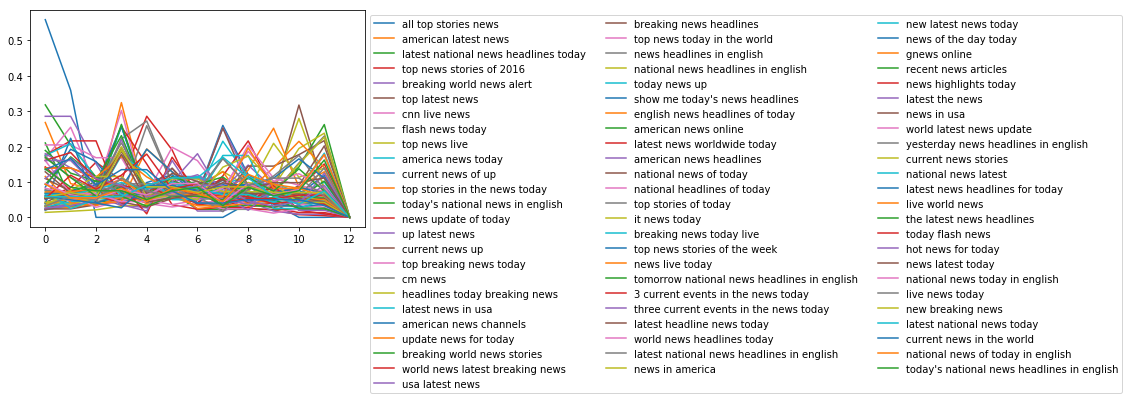

In [2]:
easydict = {}

for row in df.iterrows():
    temp = []
    temp2 = []
    index, data = row
    
    temp.append(data.tolist())
    for item in temp:
        for num in item: 
#             print num
            try:
                temp2.append(float(num))
            except: 
                pass
            
    total = sum(temp2)
    temp3 = [x/total for x in temp2]
    
    plt.plot(temp3, label = row[0])
    easydict[row[0]] = temp2

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=3)
plt.show()

Lots of spikey data, wonderful! 

Lets set up the DWT module used from [this fantastic blog post](http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb).. and for the hell of it, lets set up Uclidian distance too... just to show how useless it is!

In [3]:
#defining Dynamic Time warping and more efficient method
def DTWDistance(s1, s2):
    """ http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb  """
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))

def DTWDistance2(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [4]:
#testing the dwt
print easydict["all top stories news"]
print easydict["american latest news"]


print DTWDistance(pd.Series(easydict["all top stories news"]), pd.Series(easydict["american latest news"]))
print DTWDistance2(pd.Series(easydict["all top stories news"]), pd.Series(easydict["american latest news"]), 10)


[140.0, 90.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 10.0, 0.0, 0.0, 0.56]
[210.0, 260.0, 320.0, 2900.0, 390.0, 1000.0, 1000.0, 590.0, 880.0, 590.0, 480.0, 320.0, 0.300894855]
3212.44997878
3227.73741903


Looks like it's working! 10 is a reasonable sample for these graphs... I think!

From this lets build a similarity matrix of how similar each graph is to each other. 

In [5]:


similarity_matrix = []

for x in easydict: 
    temp = []
    for y in easydict:
        temp.append(DTWDistance2(pd.Series(easydict[x]), pd.Series(easydict[y]), 3))
    similarity_matrix.append(temp)
#     print ""

I tried printing it out but it's a long old array so just assume there's a dense matrix (you're a dense matrix)! 

Joking aside, let's train our system on the similarity matrix; 

In [6]:
from sklearn.cluster import KMeans

number_clusters = 7

pred = KMeans(n_clusters =number_clusters, random_state = 0).fit_predict(similarity_matrix)



Did it work???

[0 0 0 0 3 0 5 0 0 0 5 0 0 0 0 0 5 0 0 0 0 0 3 0 3 0 0 0 0 5 0 5 0 0 0 5 2
 3 0 0 0 0 0 0 5 0 0 5 0 0 3 0 0 0 0 0 0 5 5 0 1 0 5 5 0 0 3 6 4 0 3 5 0]


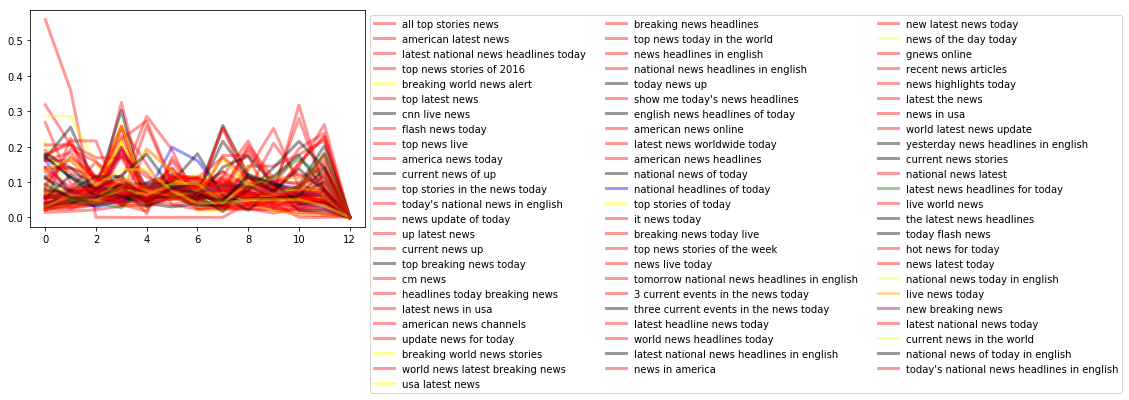

In [7]:
print pred

list_of_colours = ["red", "green", "blue", "yellow", "purple", "black", "orange"]

for enum, row in enumerate(df.iterrows()):
#     print row
    temp = []
    temp2 = []
    index, data = row
    
    temp.append(data.tolist())
    for item in temp:
        for num in item: 
#             print num
            try:
                temp2.append(float(num))
            except: 
                pass
            
    total = sum(temp2)
    temp3 = [x/total for x in temp2]
    plt.plot(temp3, label = row[0], color = list_of_colours[pred[enum]], alpha = 0.4, linewidth = 3)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=3)
plt.show()

Understandable that there's one big group and the others being slightly different. If we're looking at the patterns of the graphs, this kind of density isn't great but it looks like red is the most spiky (one spike) and blue is double spikes. 

Let's take a closer look! 

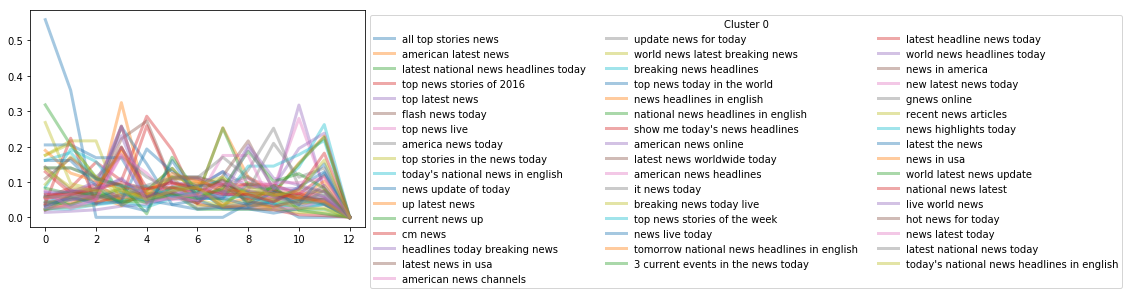

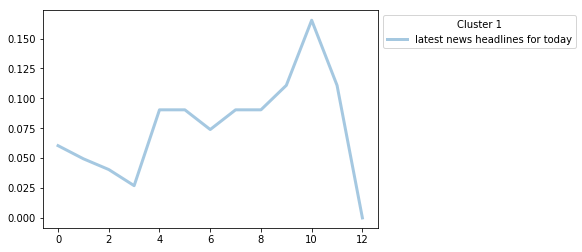

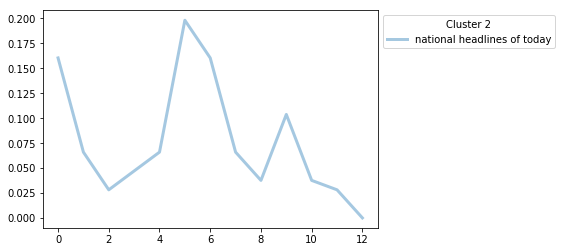

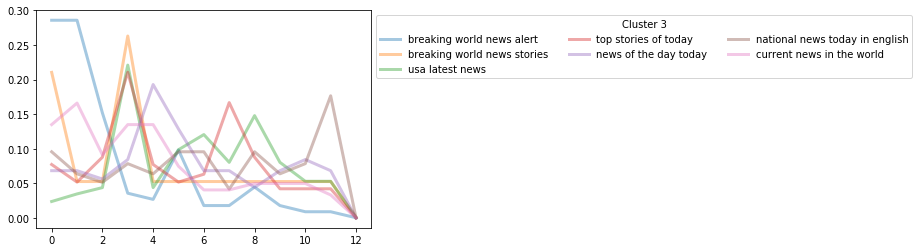

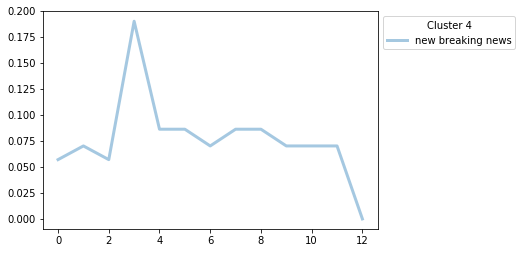

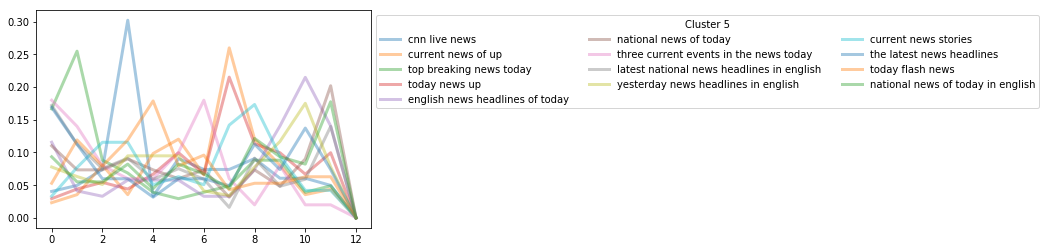

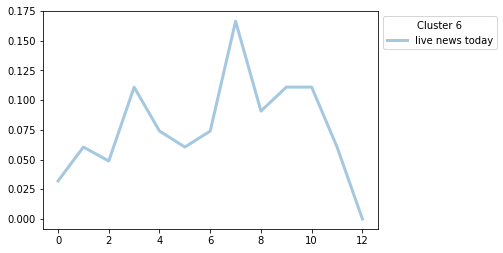

In [8]:
for cluster_num in range(number_clusters): 
    for enum, row in enumerate(df.iterrows()):
    #     print row
        temp = []
        temp2 = []
        if pred[enum] == cluster_num:
            index, data = row

            temp.append(data.tolist())
            for item in temp:
                for num in item: 
        #             print num
                    try:
                        temp2.append(float(num))
                    except: 
                        pass

            total = sum(temp2)
            temp3 = [x/total for x in temp2]
            plt.plot(temp3, label = row[0], alpha = 0.4, linewidth = 3)

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=3, title = "Cluster {0}".format(cluster_num))
    plt.show()

Ok, so I'll level with you, I didn't analyse these clusters too closely BUT I did have a rough guess at the clusters that are: being thrown out. 

#### Cluster 0
* Looks like a single spike and then a consistant rest of year

#### Cluster 1
* One of the 4 anomolies that the system threw out. I understand KMeans is known for this in smaller sets. I think given more time and a commercial setting I might use more keywords and more clusters. I also understand around 1/5 of n is fairly typical. 

#### Cluster 3
* Double spikes, all of them have two spikes!! They also look like they might be decreasing towards the end of the year. 

#### Cluster 5
* Tripple spikes that look like they are growing at the end of the year!

Honestly, I'm pretty happy with how they turned out. Sure I might be seeing something that isn't relevent to the actual clustering vectors but I'm excited by how intelligible it is overall! 

## Core Questions Revisited!

### What are the applications? 

When there are distinct seperate concepts, audiences or homonyms, looking for differences in the search volumes might differentiate between them. These audiences will be looking for different things but this may not be clear from the keyword alone. 

There might also be seperate outputs along with the different inputs ie. different strategies for more unstable keywords, growing keywords, slow moving ect keywords. 

### What is the reliability? 

To determine this I'd want to take the system and insert the same kind of regular curves that are used in the blog I used the DTW from. The intensity of the data is a little much for my little mind to take in. 

### How meaningful can this insight be?

Problem is that it does require manual insight, potentially with the analyst looking at each cluster induvidually to apply a name to it to understand what is being clustered to. 

Furthermore, the normalised nature of the graph (not taking into account the log-normal distribution of average search volume) conceals the reletive importance of the keywords from the KMeans.

### When compared to a montly peak grouping, are there significant advantages? 

This is a great question but something that I'll have to look into at another point. 

### what are some example insights from this? 

These keywords are all spikey and these are all smooth growing. 

Likely that the smooth are good for product development whereas the spikes can be good for social media mentions. 